# Friendly Streets: A Street View Classifier for Cautious Cyclists

Josh Sennett, Evan Rourke

In this notebook, we develop, train, and evaluate our final model. 

## Setup 

In [4]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
from PIL import Image

# Custom imports
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn

# Imports from files in project/
import sys
sys.path.append("../../")
from run_placesCNN_unified import load_labels, returnCAM, hook_feature
import wideresnet
from timeit import default_timer as timer
import pandas as pd
import copy

## Data Parameters

In [5]:
# Data location
datadir = '../data/images/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'
trainsampledir = datadir + 'train_sample/'
valsampledir = datadir + 'val_sample/'


# Output files
save_file_name = 'places365-transfer-v1.pt'
checkpoint_path = 'places365-transfer-v1.pth'

# Batch size
batch_size = 128

# GPU Settings
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    
# Images per set
for group in ['train', 'val', 'test']:
    for label in [0, 1]:
        path = datadir + group + '/' + str(label)
        print(group, label, '-', len(os.listdir(path)))

Train on gpu: True
1 gpus detected.
train 0 - 4392
train 1 - 5970
val 0 - 1541
val 1 - 1913
test 0 - 1454
test 1 - 2000


## Image Preprocessing

In [6]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
        trn.Compose([
        trn.Resize(size=256),
        trn.RandomRotation(degrees=15),
        trn.ColorJitter(),
        trn.RandomHorizontalFlip(),
        trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # Validation does not use augmentation
    'val':
        trn.Compose([
        trn.Resize(size=256),
        trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # Test does not use augmentation
    'test':
        trn.Compose([
        trn.Resize(size=256),
        trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Data Iterators

In [7]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [8]:
data = {
    'train': ImageFolderWithPaths(root=traindir, transform=image_transforms['train']),
    'val': ImageFolderWithPaths(root=validdir, transform=image_transforms['val']),
    'test': ImageFolderWithPaths(root=testdir, transform=image_transforms['test']),
    'train_sample': ImageFolderWithPaths(root=trainsampledir, transform=image_transforms['train']),
    'val_sample': ImageFolderWithPaths(root=valsampledir, transform=image_transforms['val']),
}


# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True),
    'train_sample': DataLoader(data['train_sample'], batch_size=batch_size, shuffle=True),
    'val_sample': DataLoader(data['val_sample'], batch_size=batch_size, shuffle=True),
}

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
print(features.shape, labels.shape, 'batch dimensions')
print(len(data['train'].classes), 'classes')

## Create the model

In [7]:
def load_base_models(num_models):
    models = []
    
    # Load the wideresnet model
    model = wideresnet.resnet18(num_classes=365)
    
    # Load in the pretrained weights
    model_file = 'wideresnet18_places365.pth.tar'
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)

    # Set class to idx crosswalks
    model.class_to_idx = data['train'].class_to_idx
    model.idx_to_class = {
        idx: class_ for class_, idx in model.class_to_idx.items()
    }
    
    # Freeze model weights
    for param in model.parameters():
        param.requires_grad = False

    # Move to GPU
    if train_on_gpu:
        for m in models:
            m.to('cuda')
    
    # Make copies of the model so that we can try variations
    for i in range(num_models):
        models.append(copy.deepcopy(model))
        
    return models    

def load_model():
    
    # Load the wideresnet model
    model = wideresnet.resnet18(num_classes=365)
    
    # Load in the pretrained weights
    model_file = 'wideresnet18_places365.pth.tar'
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
#     # Add hooks for attributes and CAM
    features_names = ['layer4','avgpool']
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)

    # Freeze model weights
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer with a FC mapping to binary classes
    n_inputs = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(n_inputs, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
        torch.nn.Linear(256, 2), torch.nn.LogSoftmax(dim=1))
    
    # Move to GPU
    if train_on_gpu:
        model = model.to('cuda')
    
    return model

## Save and Checkpoint methods

In [8]:
def save_checkpoint(model, path):
    model_name = path.split('-')[0]

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }
    
    checkpoint['fc'] = model.fc
    checkpoint['state_dict'] = model.state_dict()
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)
    

def load_checkpoint(path, fc=None):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]

    # Load in checkpoint
    checkpoint = torch.load(path)
    
    model = load_model()
    if fc == None:
        model.fc = checkpoint['fc']
    else:
        model.fc = fc

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])
    
    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Checkpointed model loaded in.")
#     display_param_counts(model)

    return model, optimizer

## Display Models

In [9]:
def display_param_counts(models):

    for model in models:
        print("**************")
        print(model.fc)
        total_params = sum(p.numel() for p in model.parameters())
        print(f'{total_params:,} total parameters.')
        total_trainable_params = sum(
            p.numel() for p in model.parameters() if p.requires_grad)
        print(f'{total_trainable_params:,} total gradient parameters.')

## Define Train Method

In [10]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=30,
          print_every=2):
    
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target, paths) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target, path in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

# Train Final Model

In [11]:
# Define which parameters we'll use for the final model
final_model = load_base_models(1)[0]
n_classes = 2
lr = .1
h = 400
r = 1e-5

final_model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, h), 
    torch.nn.LeakyReLU(negative_slope = 0.01),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(h, h), 
    torch.nn.LeakyReLU(negative_slope = 0.01),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(h, n_classes),
    torch.nn.LogSoftmax(dim=1)
)

final_optimizer = torch.optim.SGD(final_model.parameters(), 
                                  lr=lr, momentum=0.9, 
                                  weight_decay=r)
final_criteria = torch.nn.CrossEntropyLoss()

# ensure model is on cuda
final_model.to('cuda')
print("model is on cuda:", next(final_model.parameters()).is_cuda)

model is on cuda: True


In [12]:
final_model_out, final_history = train(
    final_model,
    final_criteria,
    final_optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name='places365-transfer-final-v2.pt',
    max_epochs_stop = 10,
    n_epochs= 100,
    print_every=5
)
save_checkpoint(final_model_out, 'places365-transfer-final-v2.pth')
final_history.to_csv('final_history.csv')

Starting Training from Scratch.

Epoch: 4	100.00% complete. 120.04 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6111 	Validation Loss: 0.6240
		Training Accuracy: 65.95%	 Validation Accuracy: 64.71%
Epoch: 9	100.00% complete. 118.56 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.6070 	Validation Loss: 0.6013
		Training Accuracy: 66.16%	 Validation Accuracy: 68.50%
Epoch: 14	100.00% complete. 118.20 seconds elapsed in epoch.
Epoch: 14 	Training Loss: 0.5887 	Validation Loss: 0.5934
		Training Accuracy: 68.30%	 Validation Accuracy: 67.52%
Epoch: 19	100.00% complete. 116.83 seconds elapsed in epoch.
Epoch: 19 	Training Loss: 0.5879 	Validation Loss: 0.6049
		Training Accuracy: 67.90%	 Validation Accuracy: 65.84%
Epoch: 24	100.00% complete. 120.48 seconds elapsed in epoch.
Epoch: 24 	Training Loss: 0.5827 	Validation Loss: 0.5883
		Training Accuracy: 68.08%	 Validation Accuracy: 66.39%
Epoch: 29	100.00% complete. 120.95 seconds elapsed in epoch.
Epoch: 29 	Training Loss: 0.57

## Test accuracy for a single batch

In [13]:
def accuracy(output, target):
    """ output is for a batch of images """
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=1, dim=1)
        pred = pred.t()
        
        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        correct_k = correct[:1].view(-1).float().sum(0, keepdim=True)
        res = correct_k.mul_(100.0 / batch_size).item()
        return res

In [14]:
def test_accuracy():
    testiter = iter(dataloaders['test'])
    features, targets, paths = next(testiter)
    batch_accuracy = accuracy(model(features.to('cuda')), targets)

    print("*********************")
    print("Final accuracy for a random batch of images:", batch_accuracy)
    print("*********************")

## Test accuracy for the entire test set

In [15]:
from cities_to_ways import cities_to_ways

def evaluate(model, test_loader, criterion, by_city=False, by_label=False):

    classes = []
    losses = []
    cities = []
    true_labels = []
    
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), 1))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets, paths in test_loader:
            
#             evaluation_results.append((data, targets, paths))

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true, path in zip(out, targets, paths):
                
                found_city = None
                way_id = path.split('/')[-1].split("_")[0][1:]
                for city in ['portland', 'pittsburgh', 'seattle', 'boulder']:
                    if way_id in cities_to_ways[city]:
                        found_city = city
                
                cities.append(found_city)
                    
                
                found_label = str(int(true))
                true_labels.append(found_label)
                    
          
                # Find topk accuracy
                acc_results[i, :] = accuracy(pred.unsqueeze(0), true.unsqueeze(0))
                classes.append(model.idx_to_class[true.item()])
                
                # Calculate the loss
                loss = criterion(pred.view(1, 2), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=['top1'])
    results['loss'] = losses
    group_by_cols = []

    if by_label:
        results['class'] = classes
        group_by_cols.append(classes)
    if by_city:
        results['city'] = cities
        group_by_cols.append(cities)
        
    if (by_label or by_city):
        results = results.groupby(group_by_cols).agg(['mean', 'count'])
        return results.reset_index().rename(columns={'index': 'class'})                                    
    else:
        results = results.agg(['mean','count'])
        return results.reset_index()

## Load in best model

In [ ]:
final_model, final_optimizer = load_checkpoint('places365-transfer-final-v2.pth')

In [17]:
results_by_city_label = evaluate(final_model, dataloaders['test'], torch.nn.CrossEntropyLoss(), by_city=True, by_label=True)
results_by_city = evaluate(final_model, dataloaders['test'], torch.nn.CrossEntropyLoss(), by_city=True, by_label=False)
results_by_label = evaluate(final_model, dataloaders['test'], torch.nn.CrossEntropyLoss(), by_city=False, by_label=True)
results_overall = evaluate(final_model, dataloaders['test'], torch.nn.CrossEntropyLoss(), by_city=False, by_label=False)

In [18]:
results_overall

,index,top1,loss
0,mean,68.123914,0.579974
1,count,3454.000000,3454.000000


In [19]:
results_by_label

class       top1            loss      
              mean count      mean count
0     0  57.977992  1454  0.717765  1454
1     1  75.500000  2000  0.479800  2000

In [20]:
results_by_city

class       top1            loss      
                    mean count      mean count
0     boulder  66.773163   313  0.596150   313
1  pittsburgh  64.000000   500  0.621501   500
2    portland  75.499678  1551  0.503706  1551
3     seattle  59.908257  1090  0.664805  1090

In [21]:
results_by_city_label

level_0     level_1       top1            loss      
                            mean count      mean count
0       0     boulder  60.416667    96  0.639843    96
1       0  pittsburgh  65.000000   320  0.581618   320
2       0    portland  32.602740   365  1.031265   365
3       0     seattle  68.053492   673  0.623590   673
4       1     boulder  69.585253   217  0.576820   217
5       1  pittsburgh  62.222222   180  0.692405   180
6       1    portland  88.701518  1186  0.341346  1186
7       1     seattle  46.762590   417  0.731323   417

## Visualize Results

Text(0.5,1,'Training and Validation Losses')

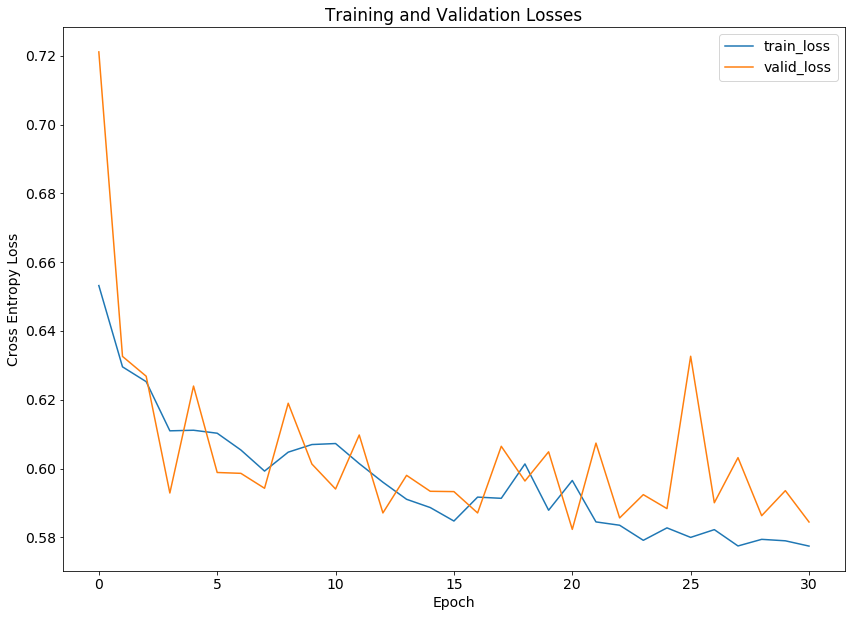

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

plt.figure(figsize=(14, 10))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        final_history[c])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Losses')

Text(0.5,1,'Training and Validation Accuracy')

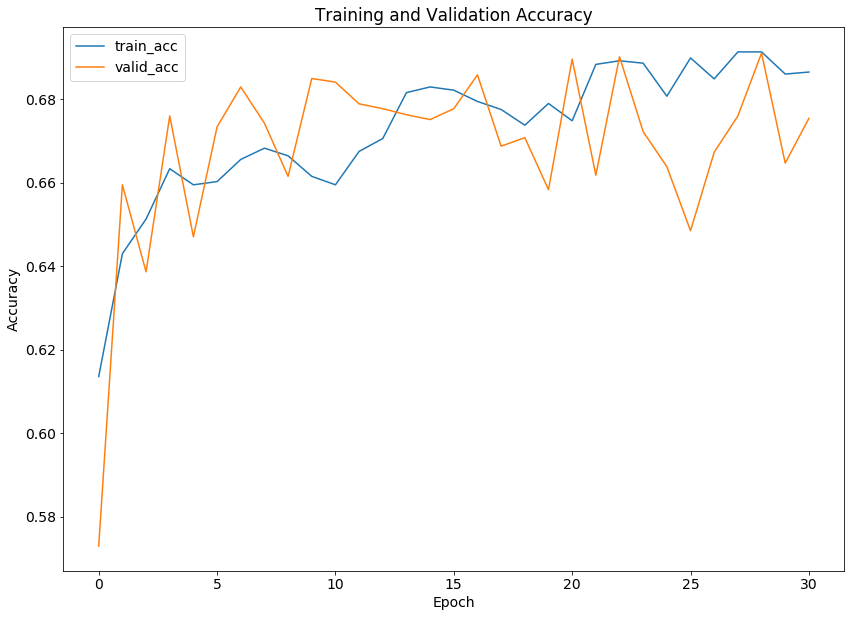

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

plt.figure(figsize=(14, 10))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        final_history[c])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')